In [1]:
import sqc
import numpy as np
from exercises import CRz,qft,twoSiteTIMsz
import matplotlib.pyplot as plt

In [2]:
def CT(c,sbits,Ntrot,dt,op,params):
    imp=params[2]
    if not imp:
        for i in range(Ntrot):
            op=CT0(c,sbits,dt/Ntrot,op,params)
            op=CT1(c,sbits,dt/Ntrot,op,params)
    else:
        op=CT0(c,sbits,dt/Ntrot/2.,op,params)
        for i in range(Ntrot-1):
            op=CT1(c,sbits,dt/Ntrot,op,params)
            op=CT0(c,sbits,dt/Ntrot,op,params)
        op=CT1(c,sbits,dt/Ntrot,op,params)
        op=CT0(c,sbits,dt/Ntrot/2.,op,params)
    return op

In [3]:
def CT0(c,sbits,dt,op,params): # prod_j exp(i (dt g / 2) X_j)
    g=params[0]
    for s in sbits:
        a=dt*g/2.
        # X.Rp[a].X.Rp[a].H.Rp[-2 a].H
        op=op.H(s)
        op=CRz(c,s,-2.*a,op)
        op=op.H(s)
        op=CRz(c,s,a,op)
        op=op.X(s)
        op=CRz(c,s,a,op)
        op=op.X(s)
    return op

def CT1(c,sbits,dt,op,params): # CNOT01.XA.RA[t].XA.RA[-t].CNOT01
    periodic=params[1]
    nmax=len(sbits)
    if not periodic:
        nmax=nmax - 1
        
    for i in range(nmax):
        a=sbits[i]
        b=sbits[(i+1)%len(sbits)]
        l=-dt/2.
        op=op.CNOT(b,a)
        op=CRz(c,a,-l,op)
        op=op.X(a)
        op=CRz(c,a,l,op)
        op=op.X(a)
        op=op.CNOT(b,a)
        
    return op

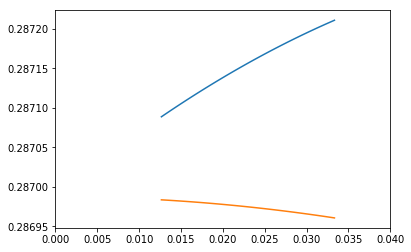

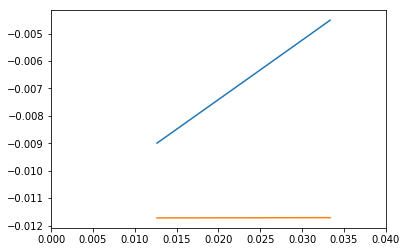

In [7]:
# extrapolation with and without improved trotter
xvals=[]
yvalsr=[]
yvalsrQ=[]
yvalsi=[]
yvalsiQ=[]

for N in range(30,80):
    s1=CT(0,[1,2,3,4],N,1.5,sqc.operator(5).X(0),[0.5,False,False])*sqc.state(5)
    s1Q=CT(0,[1,2,3,4],N,1.5,sqc.operator(5).X(0),[0.5,False,True])*sqc.state(5)
    xvals.append(1/N)
    yvalsr.append(s1[3].real)
    yvalsrQ.append(s1Q[3].real)
    yvalsi.append(s1[3].imag)
    yvalsiQ.append(s1Q[3].imag)
    
plt.xlim(0,0.04)
plt.plot(xvals,yvalsr)
plt.plot(xvals,yvalsrQ)
plt.show()

plt.xlim(0,0.04)
plt.plot(xvals,yvalsi)
plt.plot(xvals,yvalsiQ)
plt.show()


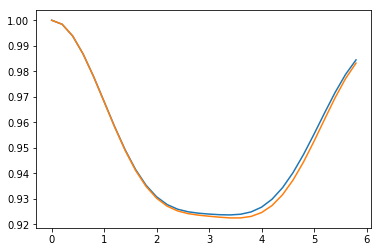

In [5]:
# time-dependent plot
xvals=[]
yvals=[]
yvals2=[]
for tstep in range(30):
    t=0.2*tstep
    xvals.append(t)
    
    s1=CT(0,[1,2,3,4],10,t,sqc.operator(5).X(0),[0.2,False,True])*sqc.state(5)
    yvals.append(abs(s1[1])**2.)
    
    s1=CT(0,[1,2,3,4],20,t,sqc.operator(5).X(0),[0.2,False,True])*sqc.state(5)
    yvals2.append(abs(s1[1])**2.)
    
plt.plot(xvals,yvals)
plt.plot(xvals,yvals2)
plt.show()

In [35]:
# ground state for g=0
def bits(y,N):
    return [ (y//2**j) % 2 for j in range(N) ]

def SZ(res,nsites):
    ntot=0.0
    dtot=0.0
    for x in res:
        n=res[x]
        dtot+=n
        bs=[ -1 if b == 1 else 1 for b in bits(x,nsites)]
        ntot+=n*sum(bs)
    return ntot/dtot/nsites

def avgZ(nsites,g,pbc):
    op=sqc.operator(nsites+1).X(0)
    s0=op*sqc.state(nsites+1)
    print(s0)

    xvals=[]
    yvals=[]
    yvals2=[]
    
    dt=0.8
    Tdt=CT(0,range(1,nsites+1),10,dt,sqc.operator(1+nsites),[g,pbc,True])
    s1=s0
    for tstep in range(25):
        t=dt*tstep
        xvals.append(t)
    
        res=SZ(sqc.sample(s1, n=1000, mask=range(1,nsites+1)),nsites)
        yvals.append(res)

        if nsites == 2 and pbc == False:
            yvals2.append(twoSiteTIMsz(t,g))
        elif nsites == 2 and pbc == True:
            yvals2.append(twoSiteTIMsz(t*2,g/2))
                
        s1=Tdt*s1
        
    
    plt.ylim(-1.1,1.1)
    plt.plot(xvals,yvals,'ro')
    if len(yvals2) != 0:
        plt.plot(xvals,yvals2)
    plt.show()

   1 * |001>


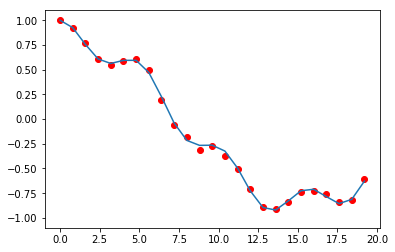

   1 * |001>


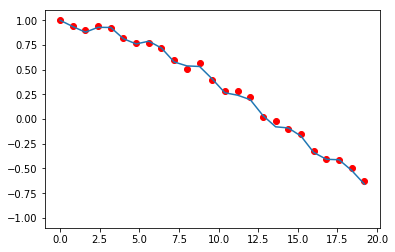

In [36]:
avgZ(2,0.5,False)
avgZ(2,0.5,True)

   1 * |001>


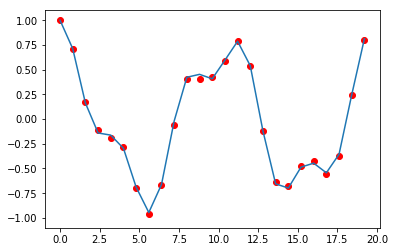

   1 * |001>


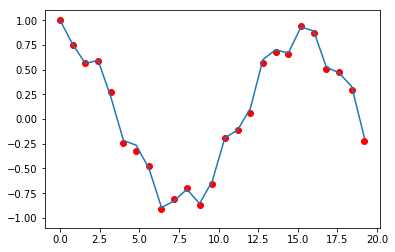

In [37]:
avgZ(2,1,False)
avgZ(2,1,True)

   1 * |00001>


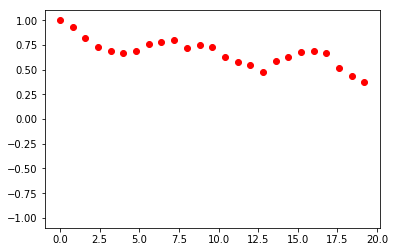

   1 * |00001>


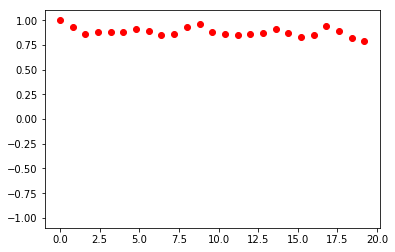

In [38]:
avgZ(4,0.5,False)
avgZ(4,0.5,True)

   1 * |0000001>


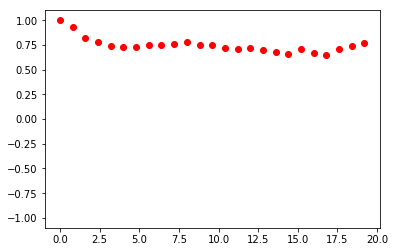

   1 * |0000001>


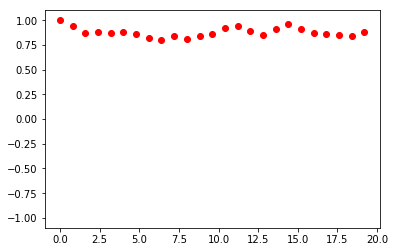

In [39]:
avgZ(6,0.5,False)
avgZ(6,0.5,True)

   1 * |00001>


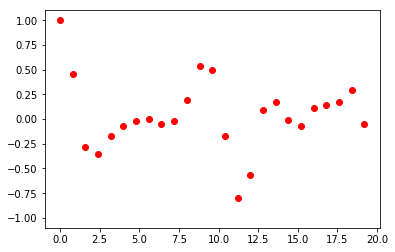

   1 * |00001>


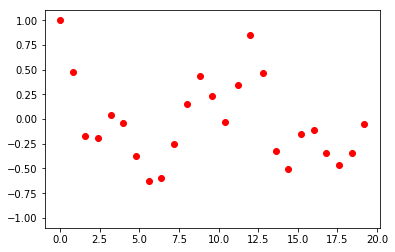

In [40]:
avgZ(4,1.5,False)
avgZ(4,1.5,True)

In [92]:
def phaseEstimate(op,xbits,cuj):
    N=len(xbits)
    for i in reversed(range(N)):
        op=op.H(xbits[i])
        op=cuj(xbits[i],2**i,op)
    op=qft(op,mask=xbits,inverse=True)
    return op

def period(x):
    if x > np.pi:
        return x - 2*np.pi
    return x

def measure(Nxbits,Nsites,Nmeasure,cuj,prep=None):
    Nbits=Nxbits+Nsites
    
    sbits=list(range(0,Nsites))
    
    xbits=list(range(Nsites,Nbits))
    
    st0=sqc.state(Nbits,basis=["|%g>|%s>" % ( period(2.*np.pi*(i//2**Nsites) / 2**Nxbits),bin(i%2**Nsites)) for i in range(2**Nbits)])
    if prep == None:
        st0=sqc.operator(Nbits)*st0
    else:
        st0=prep*st0
    print("Initial = 0\n",st0)

    st1=phaseEstimate(sqc.operator(Nbits),xbits,cuj)*st0

    if Nmeasure == 0:
        print("State after phaseEstimate\n",st1)
    else:
        res=sqc.sample(st1,Nmeasure,mask=xbits)
        
        plt.bar([ period(2.*np.pi*x / 2**Nxbits) for x in res.keys() ],res.values(),width=0.06)
        plt.xlabel('eval*t')
        plt.xlim(-np.pi,np.pi)
        plt.ylabel('count')
        plt.show()

Initial = 0
    1 * |0>|0b0>


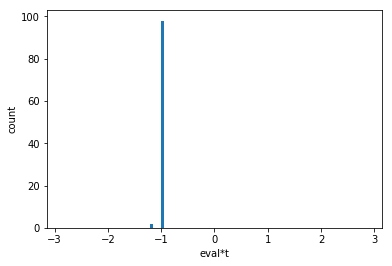

In [81]:
# two-site model at g=0 has evals at +-1/2
measure(5,2,100,lambda c,n,op: CT(c,range(2),40,2*n,op,[0.0,False,True]))

Initial = 0
    1 * |0>|0b0>


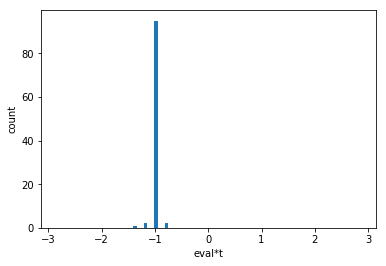

Initial = 0
    1 * |0>|0b0>


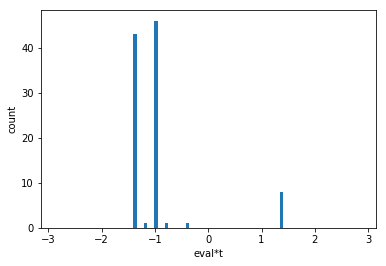

Initial = 0
    1 * |0>|0b0>


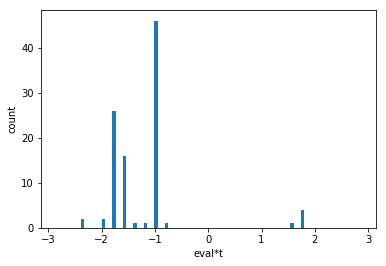

In [84]:
# two-site model at g=0 has evals at +-1/2
measure(5,2,100,lambda c,n,op: CT(c,range(2),40,2*n,op,[0.0,False,True]))
measure(5,2,100,lambda c,n,op: CT(c,range(2),40,2*n,op,[0.5,False,True]))
measure(5,2,100,lambda c,n,op: CT(c,range(2),40,2*n,op,[0.7,False,True]))

Initial = 0
    1 * |0>|0b0>


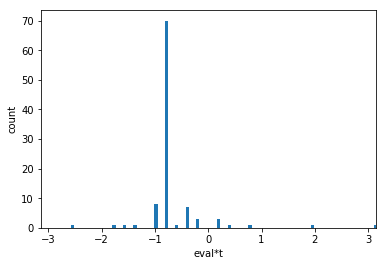

Initial = 0
    (0.0557817-0.973315j)      * |0>|0b0>
 + (0.0991756+0.0623829j)     * |0>|0b1>
 + (0.0495826+0.0896233j)     * |0>|0b10>
 + (-0.0111469+0.00894216j)   * |0>|0b11>
 + (0.0495826+0.0896233j)     * |0>|0b100>
 + (-0.0123218)               * |0>|0b101>
 + (-0.0135016+0.0021285j)    * |0>|0b110>
 + (-0.000580179-0.00163434j) * |0>|0b111>
 + (0.0991756+0.0623829j)     * |0>|0b1000>
 + (-0.0123224+0.00681333j)   * |0>|0b1001>
 + (-0.0123218)               * |0>|0b1010>
 + (-0.000292665-0.0016942j)  * |0>|0b1011>
 + (-0.0111469+0.00894216j)   * |0>|0b1100>
 + (-0.000292665-0.0016942j)  * |0>|0b1101>
 + (-0.000580179-0.00163434j) * |0>|0b1110>
 + (0.000192028-0.000106915j) * |0>|0b1111>


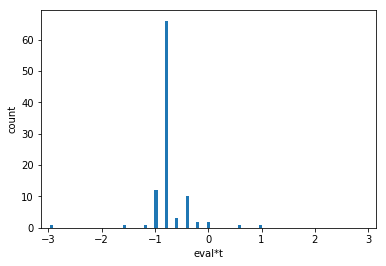

Initial = 0
    (-0.938018-0.0679972j)    * |0>|0b0>
 + (0.158204-0.123527j)      * |0>|0b1>
 + (0.115664+0.00404565j)    * |0>|0b10>
 + (0.00301014+0.0430079j)   * |0>|0b11>
 + (0.115664+0.00404565j)    * |0>|0b100>
 + (-0.019009+0.0155275j)    * |0>|0b101>
 + (-0.0244576+0.0207519j)   * |0>|0b110>
 + (-0.00776577-0.00504017j) * |0>|0b111>
 + (0.158204-0.123527j)      * |0>|0b1000>
 + (-0.00734637+0.0422007j)  * |0>|0b1001>
 + (-0.019009+0.0155275j)    * |0>|0b1010>
 + (-0.00656182-0.00646598j) * |0>|0b1011>
 + (0.00301014+0.0430079j)   * |0>|0b1100>
 + (-0.00656182-0.00646598j) * |0>|0b1101>
 + (-0.00776577-0.00504017j) * |0>|0b1110>
 + (0.000954531-0.00236738j) * |0>|0b1111>


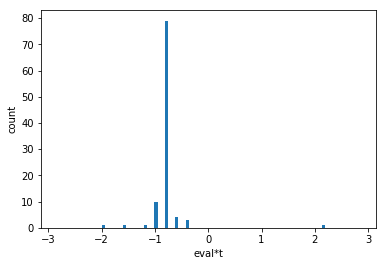

In [97]:
measure(5,4,100,lambda c,n,op: CT(c,range(4),40,0.5*n,op,[0.5,False,True]))

# Adiabatic-type method with a single time step
pr=CT(8,range(4),40,1.0,sqc.operator(9).X(8),[0.25,False,True]).X(8)
measure(5,4,100,lambda c,n,op: CT(c,range(4),40,0.5*n,op,[0.5,False,True]),pr)

# Adiabatic-type method with two steps
pr=CT(8,range(4),40,1.0,sqc.operator(9).X(8),[0.1666,False,True])
pr=CT(8,range(4),40,1.0,pr,[0.33333,False,True])
pr=pr.X(8)
measure(5,4,100,lambda c,n,op: CT(c,range(4),40,0.5*n,op,[0.5,False,True]),pr)

# We can also print out the state vector to get a better idea of the corresponding eigenstates:
#measure(5,4,0,lambda c,n,op: CT(c,range(4),40,0.5*n,op,[0.5,False,True]))